In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.fft import fft, fftfreq
from matplotlib import pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = [20, 6]

FREQUENCY = 1200
DURATION = 5
SAMPLE_RATE = FREQUENCY * 100


In [3]:
def create_t(duration, sample_rate):
    return np.linspace(0, duration, sample_rate * duration, endpoint=False)

def create_sin(x, freq):
    frequencies = x * freq
    # 2pi because np.sin takes radians
    return np.sin((2 * np.pi) * frequencies)

def create_pdf(x, mu, std):
    return stats.norm.pdf(x, mu, std) 

def moving_avg(x, n):
    d = pd.Series(x)
    return d.rolling(n, min_periods=1, center=True).mean().fillna(0.0).to_numpy()

# normalize an array to 0:1
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [4]:
def random_noise(x, factor=1):
    return np.random.random(len(x)) * factor

def random_pdf(x):
    xmax = max(x)
    mu = np.random.rand() * xmax
    std = max(0.1, min(np.random.random(), 0.9)) * xmax
    print(xmax, mu, std)
    return normalize(create_pdf(x, mu, std))

In [5]:
x = create_t(DURATION, SAMPLE_RATE)
print(x.shape, min(x), max(x), np.mean(x))

(600000,) 0.0 4.999991666666667 2.499995833333333


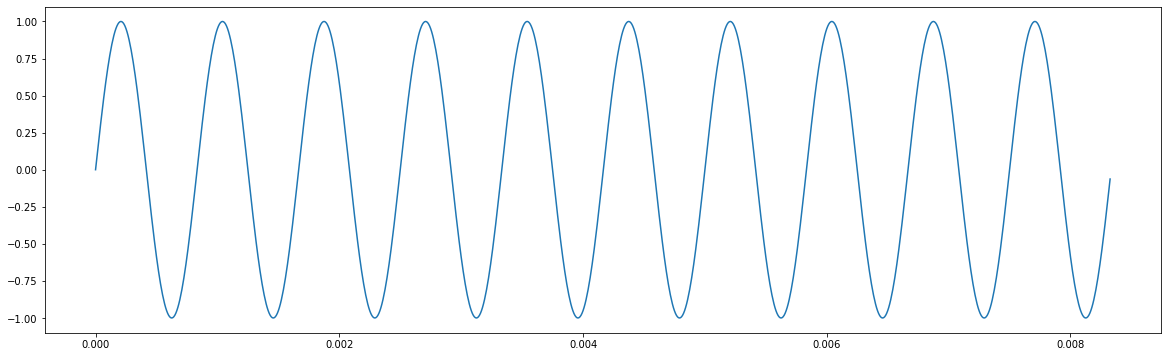

In [6]:
y_signal = create_sin(x, FREQUENCY)
plt.plot(x[:1000], y_signal[:1000])
plt.show()

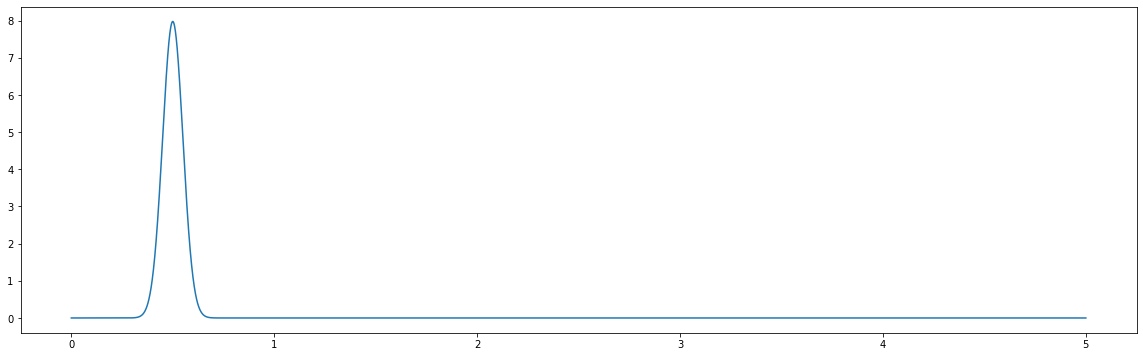

In [7]:
y = create_pdf(x, 0.5, 0.05)
plt.plot(x, y)
plt.show()

4.999991666666667 4.401867659136092 3.2622668042814227


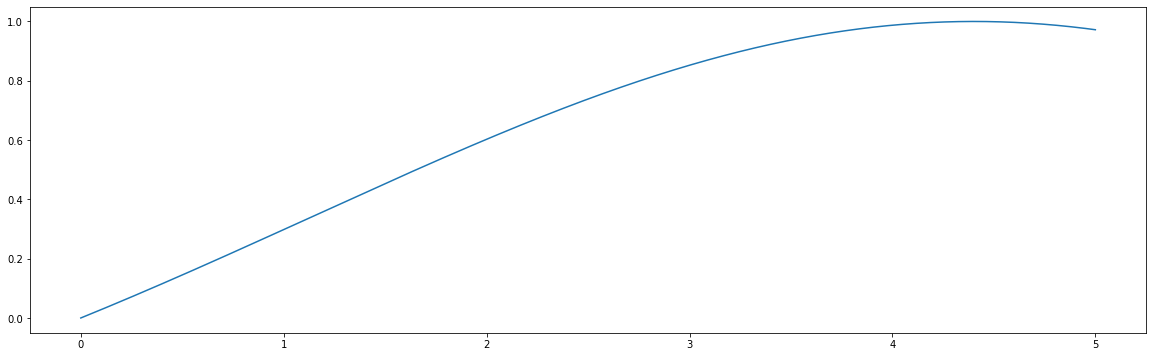

In [8]:
plt.plot(x, random_pdf(x))

4.999991666666667 0.27512026570921716 1.1318107750911304
4.999991666666667 2.13052703311707 4.4999925
4.999991666666667 1.481773555104055 2.401257824054991
4.999991666666667 1.9722709826117917 1.9473701179887455


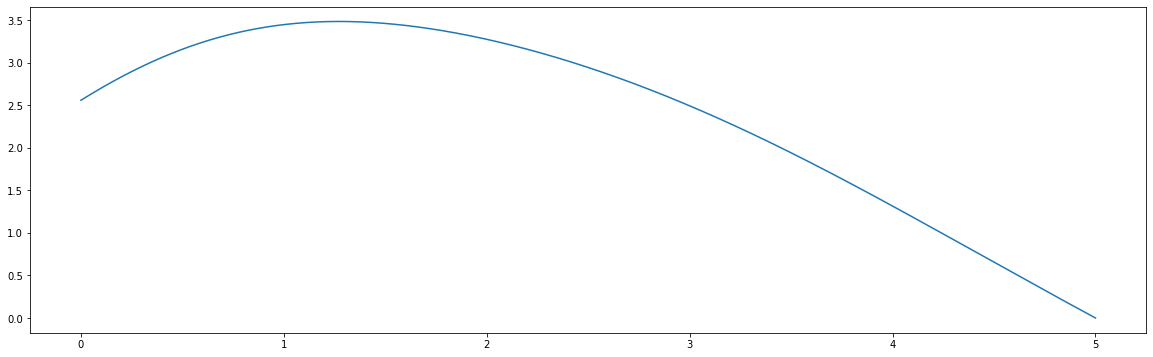

In [9]:
y = random_pdf(x) + random_pdf(x) + random_pdf(x) + random_pdf(x)
plt.plot(x, y)

4.999991666666667 2.6843973351669845 3.9267477099792756
4.999991666666667 1.310891848882559 2.9163132187714935


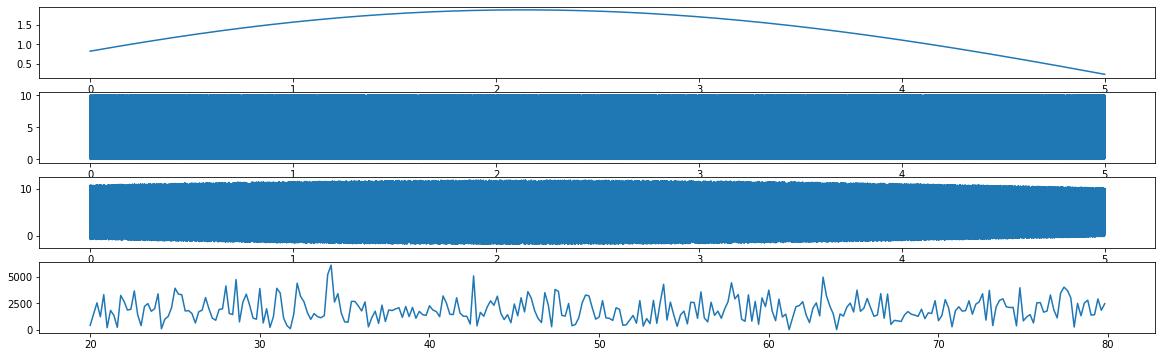

In [10]:
signal_strength = (random_pdf(x) + random_pdf(x))
y_noise = random_noise(x, 10) #+ create_sin(x, np.random.randint(10, 100))
y_signal = create_sin(x, FREQUENCY) * signal_strength + y_noise

N = SAMPLE_RATE * DURATION

from scipy.fft import rfft, rfftfreq

yf = rfft(y_signal)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


fig, axs = plt.subplots(4)
axs[0].plot(x, signal_strength)
axs[1].plot(x, y_noise)
axs[2].plot(x, y_signal)
axs[3].plot(xf[100:400], np.abs(yf)[100:400])
# axs[3].plot(xf, np.abs(yf))
plt.show()


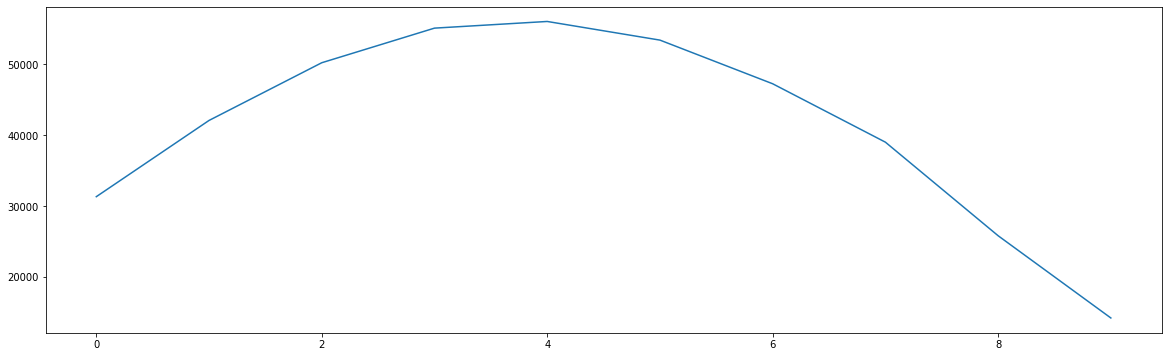

In [11]:
df = pd.DataFrame()
df['x'] = x
df['signal'] = y_signal

# split the dataframe in chunks of equal size
chunks = 10

def f(ys, freq_position=None):
    frequencies = np.abs(rfft(ys.to_numpy()))
    return frequencies[freq_position[0]:freq_position[1]].max()

# find where is the frequency inside each chunk
NC = int(SAMPLE_RATE * DURATION / chunks)
xf = rfftfreq(NC, 1 / SAMPLE_RATE)
frequency_threshold = int(FREQUENCY * 0.05)
idx = np.argwhere(abs(xf - FREQUENCY) < frequency_threshold)
freq_position = (idx.min(), idx.max())

dfg = df.groupby(np.arange(len(df)) // int(len(df) / chunks))['signal'].apply(f, freq_position=freq_position)
plt.plot(dfg)

In [12]:
dff = dfg.reset_index()

# restore timestamp
start = pd.Timestamp.utcnow()
end = start + pd.DateOffset(seconds=DURATION)

dff['time'] = pd.to_datetime(np.linspace(start.value, end.value, chunks))
dff2 = dff[dff['signal'] > 200]
dff2

,index,signal,time
0,0,31322.973310,2022-01-26 02:31:09.567470080
1,1,42092.424674,2022-01-26 02:31:10.123025664
2,2,50244.698886,2022-01-26 02:31:10.678581248
3,3,55133.236054,2022-01-26 02:31:11.234136832
4,4,56075.093130,2022-01-26 02:31:11.789692416
5,5,53441.287636,2022-01-26 02:31:12.345247744
6,6,47274.030516,2022-01-26 02:31:12.900803328
7,7,39023.989315,2022-01-26 02:31:13.456358912
8,8,25806.343290,2022-01-26 02:31:14.011914496
9,9,14187.889851,2022-01-26 02:31:14.567470080


In [13]:
dff2.time[dff2.signal.idxmax()]
dff2.time.min()

record = dict(
    ts_start = dff2.time.min(),
    ts_max = dff2.time[dff2.signal.idxmax()],
    ts_end = dff2.time.max(),
    frequency = FREQUENCY,
    power_min = dff2.signal.min(),
    power_max = dff2.signal.max(),
    power = dff2.signal.median(),
)
record

{'ts_start': Timestamp('2022-01-26 02:31:09.567470080'),
 'ts_max': Timestamp('2022-01-26 02:31:11.789692416'),
 'ts_end': Timestamp('2022-01-26 02:31:14.567470080'),
 'frequency': 1200,
 'power_min': 14187.889850876969,
 'power_max': 56075.09313015911,
 'power': 44683.22759475684}